In [1]:
from datetime import datetime
import functools
import jax
from IPython.display import HTML, display, clear_output
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx
import os

In [2]:
if 'XLA_FLAGS' in os.environ:
    print(f"XLA_FLAGS = {os.environ['XLA_FLAGS']}")
else:
    print(f"Environment variable '{'XLA_FLAGS'}' not set.")

XLA_FLAGS = --xla_gpu_triton_gemm_any=true


In [3]:
def domain_randomize(sys, rng):
  """Randomizes the mjx.Model."""
  @jax.vmap
  def rand(rng):
    _, key = jax.random.split(rng, 2)
    # friction
    friction = jax.random.uniform(key, sys.geom_friction.shape, minval=0.6, maxval=1.4)
    # actuator
    _, key = jax.random.split(key, 2)
    gain_range = (-5, 5)
    gain = jax.random.uniform(key, sys.actuator_gainprm.shape, minval=gain_range[0], maxval=gain_range[1]) 

    bias_range = (-5, 5)
    bias = jax.random.uniform(key, sys.actuator_biasprm.shape, minval=bias_range[0], maxval=bias_range[1]) 
    return friction, gain, bias

  friction, gain, bias = rand(rng)

  in_axes = jax.tree.map(lambda x: None, sys)
  in_axes = in_axes.tree_replace({
      'geom_friction': 0,
      # 'actuator_gainprm': 0,
      # 'actuator_biasprm': 0,
  })

  sys = sys.tree_replace({
      'geom_friction': friction,
      # 'actuator_gainprm': gain,
      # 'actuator_biasprm': bias,
  })

  return sys, in_axes

In [4]:
#@title Humanoid Env

class Humanoid(PipelineEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    path = epath.Path(epath.resource_path('mujoco')) / (
        'mjx/test_data/humanoid'
    )
    mj_model = mujoco.MjModel.from_xml_path(
        (path / 'humanoid.xml').as_posix())
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    sys = mjcf.load_model(mj_model)

    physics_steps_per_control_step = 5
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)
    kwargs['backend'] = 'mjx'

    super().__init__(sys, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 4)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.subtree_com[1]
    com_after = data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.q[2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.q[2] > max_z, 0.0, is_healthy)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])


envs.register_environment('humanoid', Humanoid)

In [5]:
# instantiate the environment
env_name = 'humanoid'
env = envs.get_environment(env_name)
eval_env = envs.get_environment(env_name)

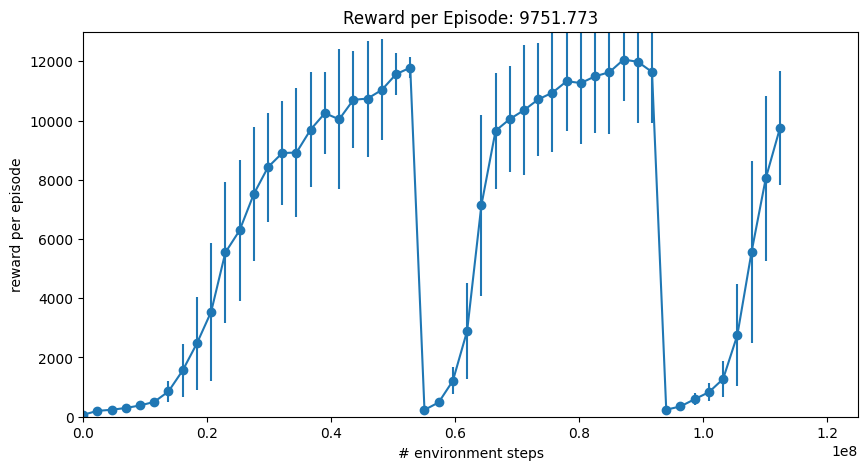

time to jit: 0:00:46.169106
time to train: 0:36:25.988398


In [6]:
train_fn = functools.partial(
    ppo.train, num_timesteps=100_000_000, num_evals=50, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=1024, seed=0, randomization_fn=domain_randomize)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 13000, 0

def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  clear_output(wait=True)

  plt.figure(figsize=(10, 5))
  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'Reward per Episode: {y_data[-1]:.3f}')

  plt.errorbar(x_data, y_data, yerr=ydataerr, fmt='-o')

  display(plt.gcf())
  plt.close()

make_inference_fn, params, _= train_fn(environment=env, eval_env=eval_env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [8]:
model_path = 'policies/humanoid_policy'
model.save_params(model_path, params)

In [13]:
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

In [14]:
eval_env = envs.get_environment(env_name)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [15]:
# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 500
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

  if state.done:
    break

media.show_video(env.render(rollout[::render_every], camera='side'), fps=1.0 / env.dt / render_every)

In [16]:
mj_model = eval_env.sys.mj_model
mj_data = mujoco.MjData(mj_model)

renderer = mujoco.Renderer(mj_model)
ctrl = jp.zeros(mj_model.nu)

images = []
for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)

  obs = eval_env._get_obs(mjx.put_data(mj_model, mj_data), ctrl)
  ctrl, _ = jit_inference_fn(obs, act_rng)

  mj_data.ctrl = ctrl
  for _ in range(eval_env._n_frames):
    mujoco.mj_step(mj_model, mj_data)  # Physics step using MuJoCo mj_step.

  if i % render_every == 0:
    renderer.update_scene(mj_data, camera='side')
    images.append(renderer.render())

media.show_video(images, fps=1.0 / eval_env.dt / render_every)